### 🔬 Estrategia de Experimentación
En este notebook realizaremos pruebas de sensibilidad cambiando dos variables críticas:

1. **Horizonte de Predicción ($h$):** Reduciremos la evaluación a 7 días. En clima, el error crece exponencialmente con el tiempo; un horizonte corto debería bajar el MASE drásticamente.
2. **Análisis de Residuos Multidimensional:** No solo veremos el error final, sino cómo evoluciona el error día a día para identificar dónde "se rompe" la lógica del modelo.

### **💻 Código del Notebook de Experimentación**

In [1]:
import pandas as pd
import numpy as np
import json
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.special import boxcox as bc_func
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

# --- 1. CARGA DE DATOS ---
df_stationary = pd.read_csv('dataset/datos_temperaturas_estacionarios.csv', index_col='Fecha', parse_dates=True)
df_original = pd.read_csv('dataset/pinar_del_rio_temperaturas_LIMPIO_FINAL.csv', index_col='Fecha', parse_dates=True)

with open('dataset/parametros_reversion.json', 'r') as f:
    params = json.load(f)

# --- 2. CONFIGURACIÓN DE EXPERIMENTOS ---
# Probaremos con tus órdenes óptimos del Grid Search
optimal_order = (2, 1)
optimal_seasonal = (0, 0, 365)
HORIZONTE_PRUEBA = 7  # CAMBIO: De 30 a 7 días

def ejecutar_experimento(h_days, p_q, P_Q_S):
    print(f"🧪 Probando Horizonte: {h_days} días | Orden: {p_q} x {P_Q_S}")
    
    # Split temporal
    train_data = df_stationary.iloc[:-h_days]
    
    # Entrenamiento
    model = VARMAX(train_data, order=p_q, seasonal_order=P_Q_S)
    res = model.fit(disp=False, maxiter=100)
    
    # Predicción
    fcast = res.get_forecast(steps=h_days).predicted_mean
    
    # Reversión
    idx_ref = len(df_original) - h_days - 1
    last_val_max = df_original['Temp_Maxima_C'].iloc[idx_ref]
    last_val_min = df_original['Temp_Minima_C'].iloc[idx_ref]
    
    last_bc_max = bc_func(last_val_max, params['boxcox_lambda']['maxima'])
    last_bc_min = bc_func(last_val_min, params['boxcox_lambda']['minima'])
    
    def rev(diff_series, last_bc, lmbda):
        return np.power(lmbda * (np.cumsum(diff_series) + last_bc) + 1, 1/lmbda)
    
    p_max = rev(fcast['Diff_BoxCox_Max'], last_bc_max, params['boxcox_lambda']['maxima'])
    p_min = rev(fcast['Diff_BoxCox_Min'], last_bc_min, params['boxcox_lambda']['minima'])
    
    r_max = df_original['Temp_Maxima_C'].iloc[-h_days:].values
    r_min = df_original['Temp_Minima_C'].iloc[-h_days:].values
    
    return r_max, p_max, r_min, p_min

# --- 3. EJECUCIÓN Y COMPARATIVA ---
real_max, pred_max, real_min, pred_min = ejecutar_experimento(HORIZONTE_PRUEBA, optimal_order, optimal_seasonal)

# --- 4. MÉTRICAS DETALLADAS ---
def get_mase(real, pred, hist):
    naive_error = np.mean(np.abs(np.diff(hist)))
    return mean_absolute_error(real, pred) / naive_error

mase_max = get_mase(real_max, pred_max, df_original['Temp_Maxima_C'].iloc[:-HORIZONTE_PRUEBA])
mase_min = get_mase(real_min, pred_min, df_original['Temp_Minima_C'].iloc[:-HORIZONTE_PRUEBA])

print(f"\n✅ RESULTADO A 7 DÍAS:")
print(f"MASE Máxima: {mase_max:.4f}")
print(f"MASE Mínima: {mase_min:.4f}")

🧪 Probando Horizonte: 7 días | Orden: (2, 1) x (0, 0, 365)

✅ RESULTADO A 7 DÍAS:
MASE Máxima: 1.9503
MASE Mínima: 1.9819


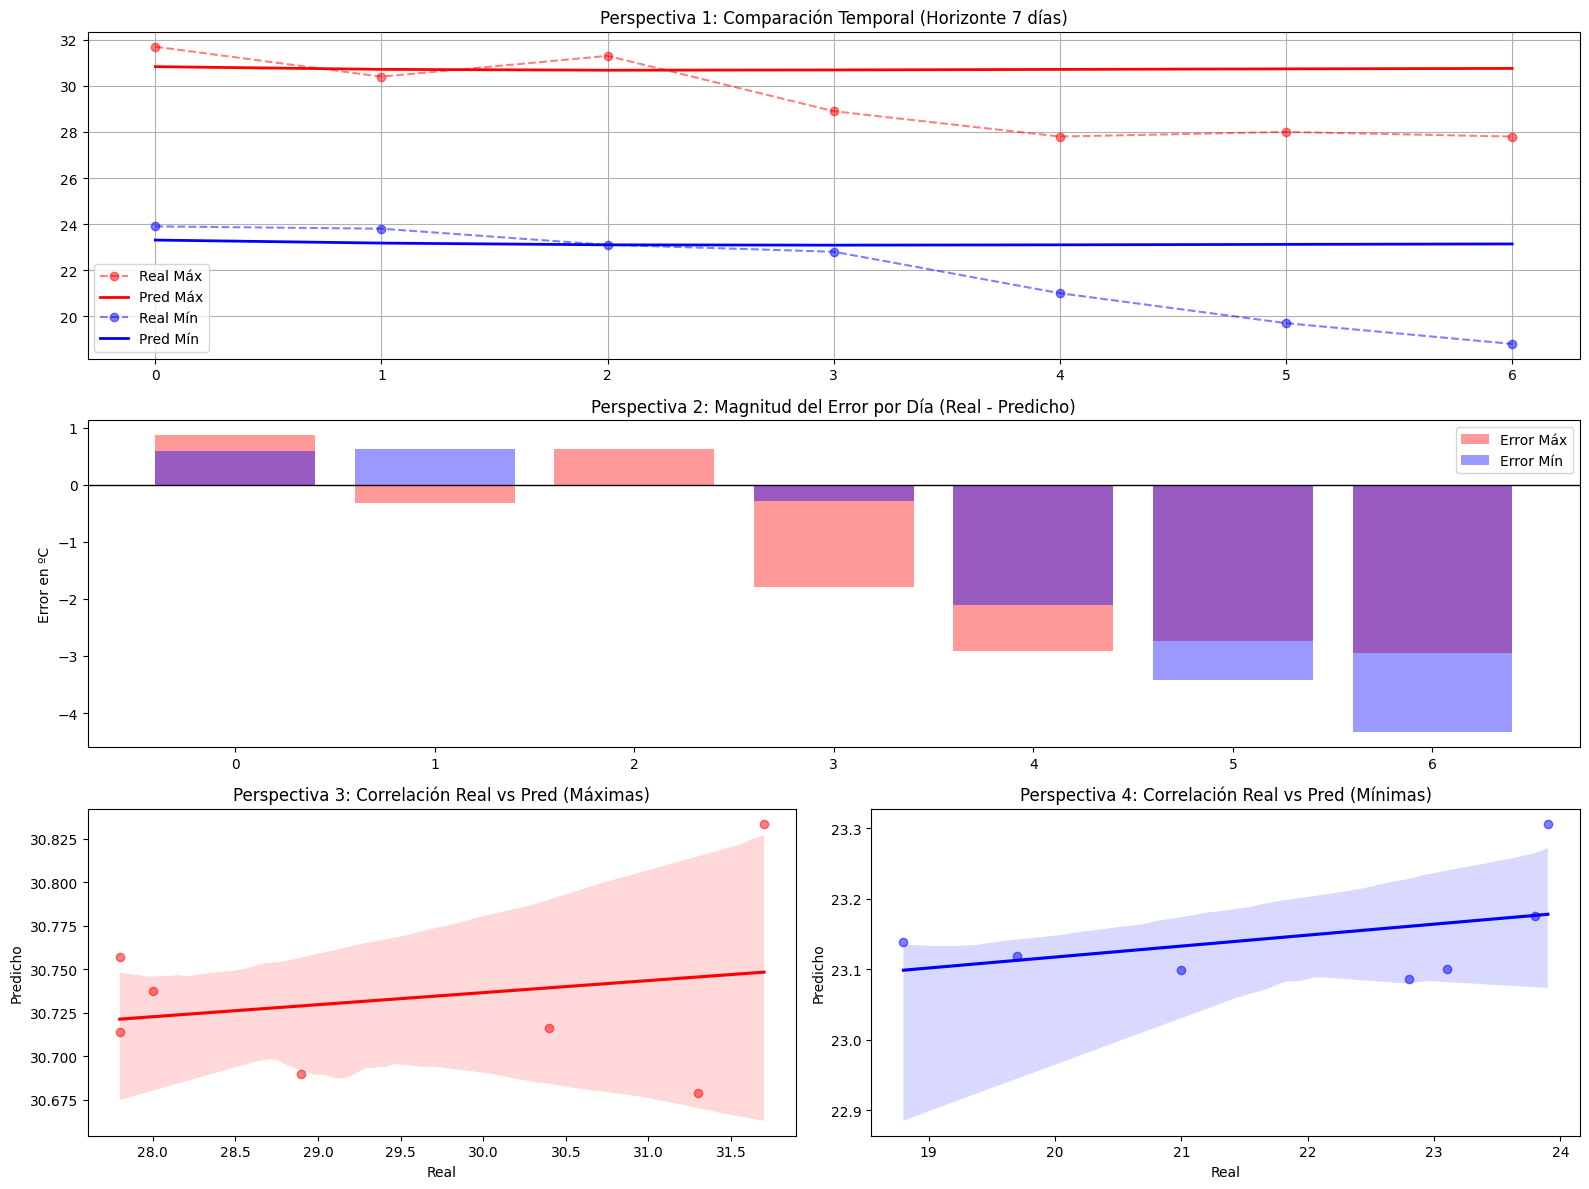

In [2]:
# --- 5. VISUALIZACIÓN MULTI-PERSPECTIVA ---
plt.figure(figsize=(16, 12))

# A. Comparación de Líneas (Zoom al Horizonte)
plt.subplot(3, 1, 1)
plt.plot(real_max, 'ro--', label='Real Máx', alpha=0.5)
plt.plot(pred_max.values, 'r-', label='Pred Máx', linewidth=2)
plt.plot(real_min, 'bo--', label='Real Mín', alpha=0.5)
plt.plot(pred_min.values, 'b-', label='Pred Mín', linewidth=2)
plt.title(f'Perspectiva 1: Comparación Temporal (Horizonte {HORIZONTE_PRUEBA} días)')
plt.legend()
plt.grid(True)

# B. Gráfico de Error por Día (¿Dónde falla más?)
plt.subplot(3, 1, 2)
err_max = real_max - pred_max.values
err_min = real_min - pred_min.values
plt.bar(range(HORIZONTE_PRUEBA), err_max, color='red', alpha=0.4, label='Error Máx')
plt.bar(range(HORIZONTE_PRUEBA), err_min, color='blue', alpha=0.4, label='Error Mín')
plt.axhline(0, color='black', lw=1)
plt.title('Perspectiva 2: Magnitud del Error por Día (Real - Predicho)')
plt.ylabel('Error en ºC')
plt.legend()

# C. Scatter Plot (Correlación de Predicción)
plt.subplot(3, 2, 5)
sns.regplot(x=real_max, y=pred_max.values, color='red', scatter_kws={'alpha':0.5})
plt.title('Perspectiva 3: Correlación Real vs Pred (Máximas)')
plt.xlabel('Real')
plt.ylabel('Predicho')

plt.subplot(3, 2, 6)
sns.regplot(x=real_min, y=pred_min.values, color='blue', scatter_kws={'alpha':0.5})
plt.title('Perspectiva 4: Correlación Real vs Pred (Mínimas)')
plt.xlabel('Real')
plt.ylabel('Predicho')

plt.tight_layout()
plt.show()